# Integrated Gradient
<center>
<img src="https://raw.githubusercontent.com/TianhongDai/integrated-gradient-pytorch/master/figures/inception.png" width="500">
</center>



**Chain rule does not hold for discrete gradient.**

$$
\frac{f(x_1) - f(x_0)}{g(x_1) - g(x_0)} \ne \frac{f(x_1) - f(x_0)}{h(x_1) - h(x_0)} \cdot \frac{f(h_1) - f(h_0)}{g(x_1) - g(x_0)}
$$

Therefore vanilla gradient methods fail to satisfy implementation invariance.

If an attribution method fails to satisfy Implementation Invariance, the attributions are potentially sensitive to unimportant aspects of the models.



**Path Method**

<center>
<img src='https://miro.medium.com/max/902/0*zIbdDZCGdIQh-ay6' width=250>
</center>

$$
\text{IntegratedGrads}_{i}^{approx} (x) ::= (x_i - x_i ') \times \sum_{k=1}^{m} \frac{\partial F (x' + \alpha \times (x-x'))}{\partial x_i} \times \frac{1}{m}
$$

All path methods satisfy Implementation Invariance. This follows from the fact that they are defined
using the underlying gradients, which do not depend on the
implementation.





# Import module


In [0]:
# import module
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline  
import random

# Hyperparameters



In [0]:
batch_size = 16
learning_rate = 0.0001
num_epoch = 10

# Data load: MNIST


In [0]:
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(226),
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

mnist_test = dset.MNIST("./", train=False,
                        transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(226),
                            transforms.ToTensor(),
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

0it [00:00, ?it/s]

9920512it [00:01, 8682698.22it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130065.91it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 2144481.90it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 49484.47it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


# Model


In [0]:
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function, Variable
from torchvision import models

In [0]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.6MB/s]


In [0]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.cuda()
for i in range(num_epoch):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image)                             
        x = torch.cat([x, x, x], dim=1).type(torch.FloatTensor).cuda()
        y_= Variable(label).cuda()
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
         
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    model.eval() 
    for image,label in test_loader:
        x = Variable(image)
        x = torch.cat([x, x, x], dim=1).type(torch.FloatTensor).cuda()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))
    if (top_1_count/total).numpy() > 0.98:
        break


Test Data Accuracy: [98.99]%


## Identify baseline tensor and input tensor

In [0]:
for img, label in train_loader:
    images, labels = img, label
    break

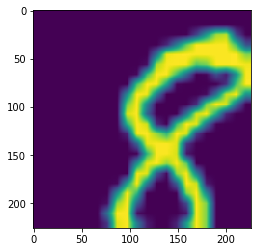

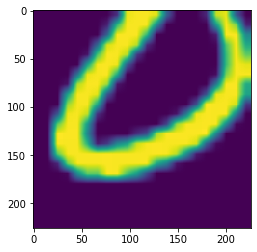

In [0]:
img0 = images[0].numpy()[0]
img1 = images[1].numpy()[0]

plt.imshow(img0)
plt.show()

plt.imshow(img1)
plt.show()

In [0]:
input = torch.unsqueeze(torch.cat([images[0]] * 3, dim=0), 0)
input.retain_grad()
baseline = torch.unsqueeze(torch.cat([images[1]] * 3, dim=0), 0)



## Get integrated gradient!


In [0]:
step = 100
ig = torch.zeros(1, 3, 226, 226).cuda()
grad = torch.zeros(1, 3, 226, 226).cuda()
model.cuda()
baseline = torch.zeros(1, 3, 226, 226)
for i in range(step + 1):
    alpha = i / step
    input = Variable(input, requires_grad=True)
    input.retain_grad()
    tensor = baseline - alpha * (input - baseline)
    output = model(tensor.cuda())
    output.backward(torch.Tensor([[1.0] * 10]).cuda())
    ig += (input.cuda() - baseline.cuda()).cuda() * input.grad.cuda() * 1 / step

tensor = Variable(input, requires_grad=True).cuda()
tensor.retain_grad()
output = model(tensor)
output.backward(torch.Tensor([[1.0] * 10]).cuda())
grad = tensor.grad

In [0]:
ig = ig.detach().cpu().numpy()
grad = grad.detach().cpu().numpy()

In [0]:
ig = np.transpose(ig[0], (1, 2, 0))
grad = np.transpose(grad[0], (1, 2, 0))

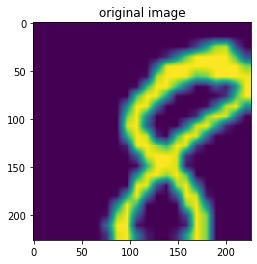

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


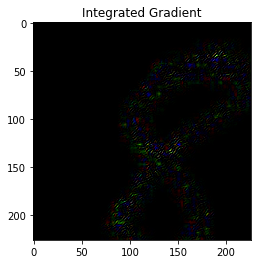

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


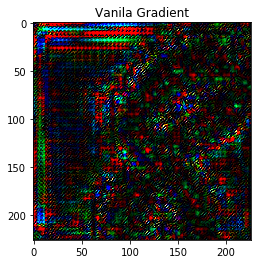

In [0]:
# Visualization
plt.imshow(img0)
plt.title('original image')
plt.show()

plt.imshow(ig)
plt.title('Integrated Gradient')
plt.show()

plt.imshow(grad)
plt.title('Vanila Gradient')
plt.show()